## End to End Project - Bike Rental Demand

Task: The dataset (Location: "datasets/bikes.csv") contains the hourly rental bike demand data. The goal is to develop a model to estimate the bike demand in future given the parameters as observed in the past.

Steps:
1. Importing the libraries
1. Defining some utility functions
1. Loading and cleaning the data
1. Adding derived features
1. Analyzing the dataset
1. Dividing the dataset into training and test dataset
1. Training several models and analyzing their performance
1. Selecting a model and evaluating using test dataset
1. Improving the model by finding the best hyper-parameters and features
1. Analyzing the residuals

### Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### Some utility functions

In [27]:
def set_day(df):
    '''
    This function assigns day names to each of the
    rows in the dataset. 
    '''
    ## Assumes the first day of the dataset is Saturday
    days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thr", "Fri"]
    temp = ['d']*df.shape[0]
    i = 0
    indx = 0
    cur_day = df.weekday[0]
    for day in df.weekday:
        temp[indx] = days[(day-cur_day+7)%7]
        indx += 1
    df['dayWeek'] = temp
    return df

# Function that takes in a dataframe with yr and mnth attribute and calculates an array denoting the month number from the start
def mnth_cnt(df):
    '''
    Compute the count of months from the start of
    the time series.
    '''
    import itertools
    yr = df['yr'].tolist()
    mnth = df['mnth'].tolist()
    out = [0] * df.shape[0]
    indx = 0
    for x, y in zip(mnth, yr):
        out[indx] = x + 12 * y
        indx += 1
    return out


# Function used to calculate the basics stats of observed scores from cross-validation of models
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Loading the data

The dataset contains the following parameters:
* instant: record index
* dteday : date
* season : season (1:spring, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* hr : hour (0 to 23)
* holiday : weather day is holiday or not (extracted from [Web Link])
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit : 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are derived via (t*t_min)/(t_max*t_min), t_min=*8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t*t_min)/(t_max*t_min), t_min=*16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

In [34]:
filePath = 'datasets/bikes.csv'
bikesData = pd.read_csv(filePath)

print(bikesData.info())
bikesData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
Unnamed: 0    17379 non-null int64
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(13), object(1)
memory usage: 2.4+ MB
None


,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [35]:
len(bikesData)

17379

### Data cleaning

Some of the attributes are not required as per the requirement of the project: ['instant','casual','registered','atemp','dteday']. These can be dropped.

Some of the numerical columns will have to be scaled: ['temp','hum','windspeed']

In [37]:
# Update the columnsToDrop variable in the order given
columnsToDrop = ['instant','casual','registered','atemp','dteday']

bikesData = bikesData.drop(columnsToDrop,1)

In [43]:
# Update the columnsToScale variable in the order given
columnsToScale = ['temp','hum','windspeed']

scaler = StandardScaler()
bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
bikesData[columnsToScale].describe()

,temp,hum,windspeed
count,1.737900e+04,1.737900e+04,1.737900e+04
mean,3.103437e-16,5.076305e-18,3.940790e-15
std,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.477205e+00,-3.251166e+00,-1.553889e+00
25%,-8.153035e-01,-7.631431e-01,-6.996886e-01
50%,1.564696e-02,1.436398e-02,3.189880e-02
75%,8.465975e-01,7.918711e-01,5.198962e-01
max,2.612367e+00,1.932215e+00,5.399871e+00


### Adding derived features and transforming the data
These features are derived from the raw set of features:
1. **isWorking:** 1: Is a workingday and not a holiday, 0: Is not a workingday and is a holiday
1. **monthCount:** count of the number of months from the beginning of the dataset
1. **xformHr:** transform by shifting the hours by 5 hrs, if the hours are greater than 5, we subtract 5, else we add 19.
1. **dayCnt:** count of the days from the beginning of the dataset
1. **xformWorkHr:** transforming the hour dataset to make the non-working days to have hours from 25 to 48
1. **cntDeTrended:** De-trended count values

In [44]:
bikesData['isWorking'] = np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)
bikesData['monthCount'] = mnth_cnt(bikesData)
bikesData['xformHr'] = np.where(bikesData.hr>4,bikesData.hr-5,bikesData.hr+19)
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData['xformWorkHr'] = (1-bikesData.isWorking)*24 + bikesData.xformHr
bikesData = set_day(bikesData)
bikesData.head()

,Unnamed: 0,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,isWorking,monthCount,xformHr,dayCount,xformWorkHr,dayWeek
0,0,1,0,1,0,0,6,0,1,-1.334648,0.947372,-1.553889,16,0,1,19,0.000000,43,Sat
1,1,1,0,1,1,0,6,0,1,-1.438516,0.895539,-1.553889,40,0,1,20,0.041667,44,Sat
2,2,1,0,1,2,0,6,0,1,-1.438516,0.895539,-1.553889,32,0,1,21,0.083333,45,Sat
3,3,1,0,1,3,0,6,0,1,-1.334648,0.636370,-1.553889,13,0,1,22,0.125000,46,Sat
4,4,1,0,1,4,0,6,0,1,-1.334648,0.636370,-1.553889,1,0,1,23,0.166667,47,Sat


In [45]:
np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)

array([0, 0, 0, ..., 1, 1, 1])

In [46]:
bikesData.sort_values('dayCount', axis= 0, inplace=True)
nrow = bikesData.shape[0]
X = bikesData.dayCount.values.reshape(nrow,1)
Y = bikesData.cnt
clf = linear_model.LinearRegression()
bike_lm = clf.fit(X, Y)

bikesData['cntDeTrended'] = bikesData.cnt - bike_lm.predict(X)

### Analyzing and visualizing the dataset

These tasks shall be performed as a part of analyzing and visualizing the dataset:
1. Hourly count of bikes with trend and without trend
1. Correlation matrix between the features and the dependent variable
1. Plotting correlation among selected variables - 'yr','mnth','isWorking','xformWorkHr','dayCount','temp','hum','windspeed','cntDeTrended'
1. Plotting the count pattern with daycount for specific hours
1. Plotting box plot for different attributes: 'hr', 'mnth', 'weathersit', 'isWorking', 'dayWeek', 'xformHr'
1. Plotting scatter matrix for selected attributes: 'temp', 'hum', 'windspeed', 'hr', 'xformHr', 'cntDeTrended'
1. Plotting box plots for 0900 and 1800 hrs working and non-working days
1. Plotting the demand counts for each of the transformed work hours which include working and non-working hours

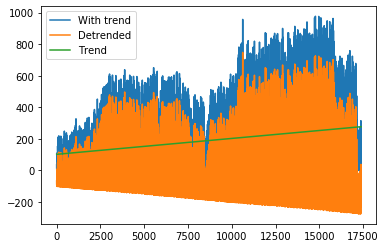

In [68]:
# Plotting the hourly count with trend and without trend.
plt.plot(bikesData.loc[:,'cnt'])
plt.plot(bikesData.loc[:,'cntDeTrended'])
plt.plot(bike_lm.predict(X))
plt.legend(['With trend','Detrended','Trend'])
plt.show()

#### Correlation Matrix
** Plot the correlation matrix between all the features and the dependent variable.

** Calculate correlation among these variables: 'yr', 'mnth', 'isWorking', 'xformWorkHr', 'dayCount', 'temp', 'hum', 'windspeed', 'cntDeTrended'

/Users/toluwalasheomotunde/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


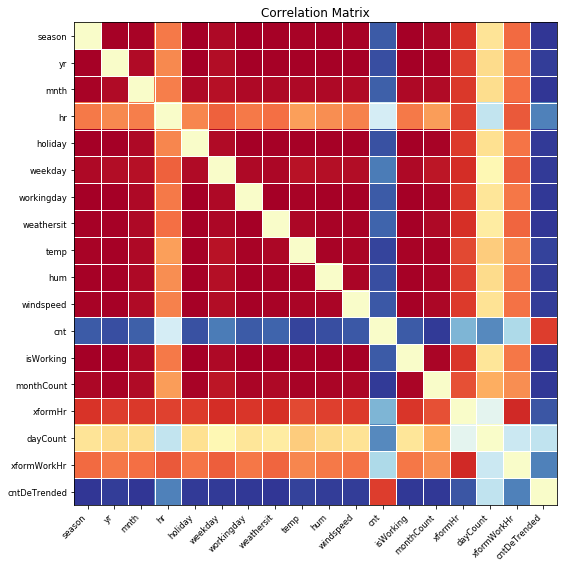

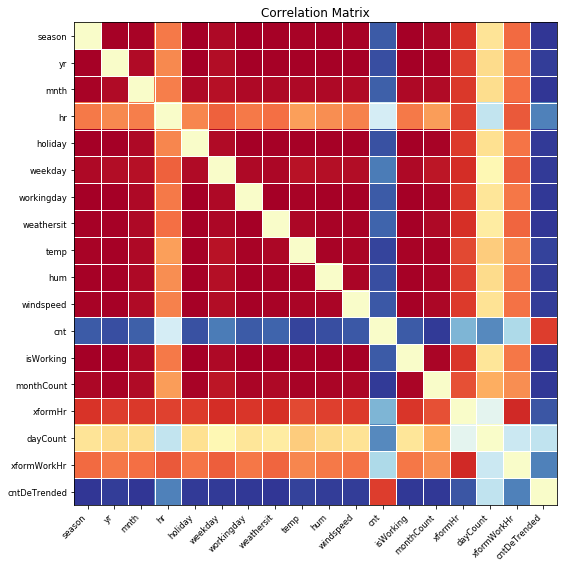

In [61]:
import statsmodels.graphics.correlation as pltcor
arr = bikesData.drop(['dayWeek','Unnamed: 0'], axis = 1)
cols = list(arr)
arr = arr.as_matrix()
arr = preprocessing.scale(arr, axis = 1)
corrMat = np.corrcoef(arr, rowvar =0)
np.fill_diagonal(corrMat, 0)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
pltcor.plot_corr(corrMat, xnames = cols, ax=ax)

In [67]:
bikesData.corr()["cnt"].drop("cnt",0)

Unnamed: 0      0.278379
season          0.178056
yr              0.250495
mnth            0.120638
hr              0.394071
holiday        -0.030927
weekday         0.026900
workingday      0.030284
weathersit     -0.142426
temp            0.404772
hum            -0.322911
windspeed       0.093234
isWorking       0.030284
monthCount      0.278580
xformHr        -0.247574
dayCount        0.278379
xformWorkHr    -0.155578
cntDeTrended    0.960471
Name: cnt, dtype: float64

#### Line Plots

** Plot cntDeTrended versus dayCount for these hours: [7, 9, 12, 15, 18, 20, 22]

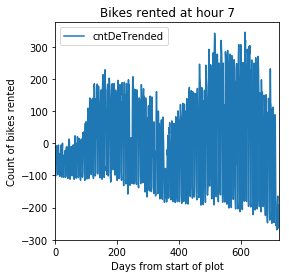

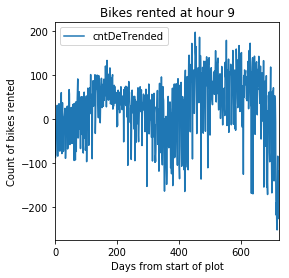

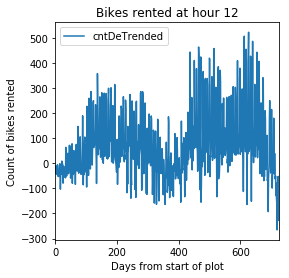

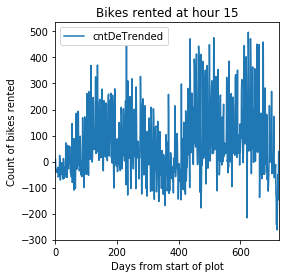

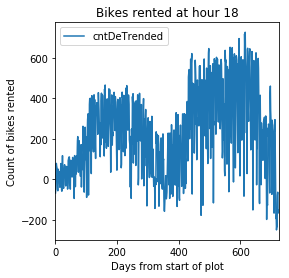

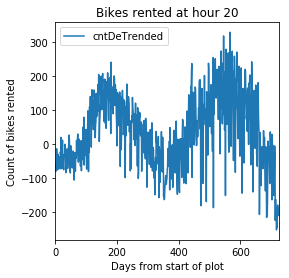

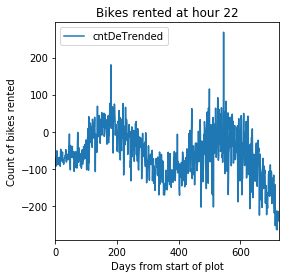

In [19]:
times = [7, 9, 12, 15, 18, 20, 22]
for time in times:
    fig = plt.figure(figsize=(4,4))
    tsToPlot = bikesData[bikesData.hr==time]
    fig.clf()
    ax = fig.gca()
    tsToPlot.plot(kind='line', x='dayCount', y='cntDeTrended', ax =ax)
    plt.xlabel("Days from start of plot")
    plt.ylabel("Count of bikes rented")
    plt.title("Bikes rented at hour " + str(time))
    plt.show()

#### Box plots

**Task:** Complete the statement to include these box plots and in this order:
['hr', 'mnth', 'weathersit', 'isWorking', 'dayWeek', 'xformHr']

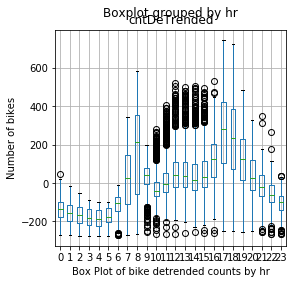

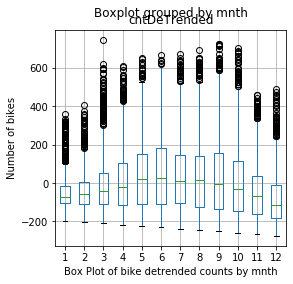

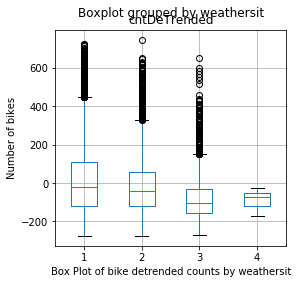

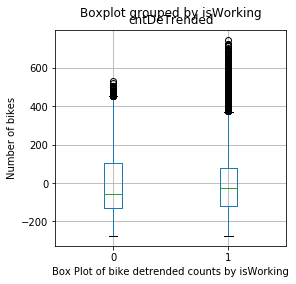

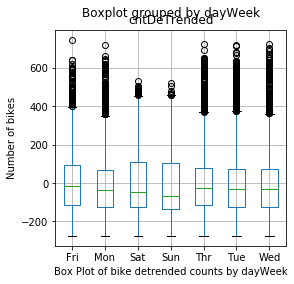

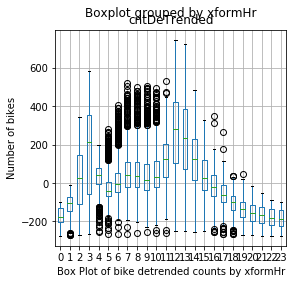

In [69]:
# Box plots for: ['hr', 'mnth', 'weathersit', 'isWorking', 'dayWeek', 'xformHr']
colstoBoxPlot = ['hr','mnth','weathersit','isWorking','dayWeek','xformHr']

for cols in colstoBoxPlot:
    fig = plt.figure(figsize=(4,4))
    fig.clf()
    ax = fig.gca()
    bikesData.boxplot(column=['cntDeTrended'], by = [cols], ax = ax)
    plt.xlabel('Box Plot of bike detrended counts by '+str(cols))
    plt.ylabel('Number of bikes')
    plt.show()

#### Scatter Matrix

** Plot of scatter matrix for: ['temp', 'hum', 'windspeed', 'hr', 'xformHr', 'cntDeTrended']

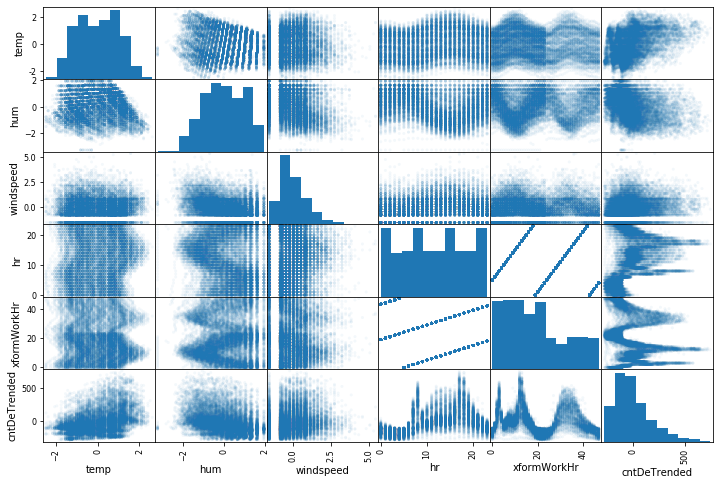

In [78]:
# Plot the scatter matrix for these columns: ['temp', 'hum', 'windspeed', 'hr', 'xformHr', 'cntDeTrended']
columnToPlotScatter = ['temp','hum','windspeed','hr','xformWorkHr','cntDeTrended']
from pandas.plotting import scatter_matrix
scatter_matrix(bikesData[columnToPlotScatter], figsize=(12,8), alpha=0.05)
plt.show()

#### Plotting box plots for 0900 and 1800 hrs working and non-working days

Contrary to the previous observation. there is perhaps an interaction between the time of day of working and nonworking days. A day of week effect is not apparent, but we may need to look in more detail. This idea is easy to explore. 

Adding the following code creates box plots for peak demand hours of working and nonworking days. Complete the code to box plot the bike counts for isWorking - [0,1] for these hours: [0700, 1700]

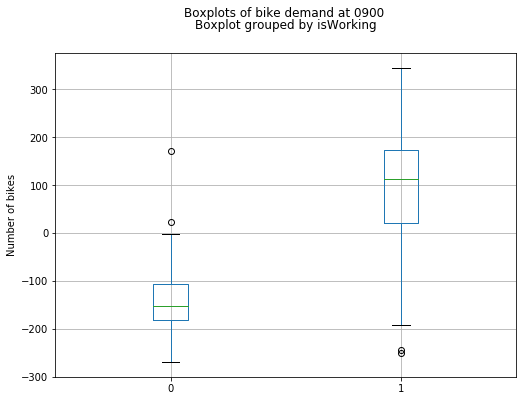

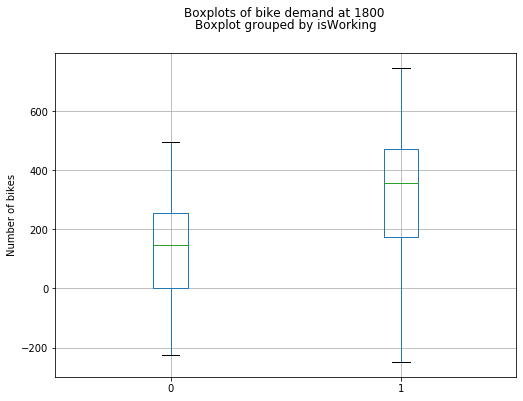

In [71]:
labels = ["Boxplots of bike demand at 0900 \n\n", "Boxplots of bike demand at 1800 \n\n"]
times = [7, 17]
# Task: Complete these statements
col = ['cntDeTrended']
byCol = ['isWorking']
for lab, tms in zip(labels, times):
    temp = bikesData[bikesData.hr == tms]
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    
    temp.boxplot(column = col, by = byCol, ax = ax)
    plt.xlabel('')
    plt.ylabel('Number of bikes')
    plt.title(lab)
    plt.show()

#### Plotting Transformed Work hours versus the count

In accordance with our previous observation, we shall plot the demand counts for each of the transformed work hours which includes working and non-working hours.

** Plot detrended count and the xformWorkHr.

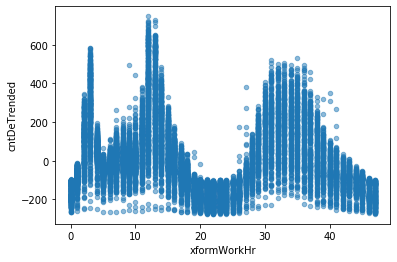

In [72]:
x_plot = 'xformWorkHr'
y_plot = 'cntDeTrended'
ax = fig.gca()
bikesData.plot(kind='scatter', x = x_plot, y = y_plot, alpha = 0.5)
plt.show()

### Dividing the dataset into training and test dataset

After having analyzed the dataset, we shall divide the entire dataset into training and test set using train_test_split in the ratio 70:30 It uses random sorting and hence the resulting train_set and test_set is sorted by daycount.

In [75]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(bikesData, test_size=0.3, random_state=42)
train_set.sort_values('dayCount', axis= 0, inplace=True)
test_set.sort_values('dayCount', axis= 0, inplace=True)
print(len(train_set), "train +", len(test_set), "test")

12165 train + 5214 test


/Users/toluwalasheomotunde/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/toluwalasheomotunde/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Training and analyze models

Models to be trained and analyzed: 
1. DecisionTreeRegressor
1. LinearRegression 
1. RandomForestRegressor

Metrics calculated: neg_mean_absolute_error, neg_mean_squared_error using cross-validation

** Stored predicted values from the classifier using cross_val_predict.

Features used:
1. xformWorkHr
1. temp
1. dayCount

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [81]:
trainingCols = train_set[['xformWorkHr','temp','dayCount']]
trainingLabels = train_set['cnt']

# Decision Tree Regressor
rfc_clf = DecisionTreeRegressor(random_state = 42)
display_scores(-cross_val_score(rfc_clf, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(rfc_clf, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_dtr = train_set.copy()
train_set_dtr['predictedCounts'] = cross_val_predict(rfc_clf, trainingCols, trainingLabels, cv=10)
train_set_dtr['resids'] = train_set_dtr['predictedCounts'] - trainingLabels

Scores: [ 29.37222679  48.46507806  37.08874281  54.01643385  54.47411668
  57.77138158  64.79029605  63.81414474  55.57401316 100.21052632]
Mean: 56.557696003438124
Standard deviation: 17.952218990725587
Scores: [ 45.95970154  74.51177712  58.77977925  88.94009321  87.18584406
  90.6675626  106.76725101 100.5444717   92.66354674 154.47246284]
Mean: 90.04924900874488
Standard deviation: 27.784382154078404


In [83]:
# Linear Regression model
lin_reg = LinearRegression()
display_scores(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_lin = train_set.copy()
train_set_lin['predictedCounts'] = cross_val_predict(rfc_clf, trainingCols, trainingLabels, cv=10)
train_set_lin['resids'] = train_set_lin['predictedCounts'] - trainingLabels

Scores: [ 62.29527472  90.60871832 134.99710104 120.7050177   87.65203691
  95.09526459 153.68788949 177.0099255  183.21306065 137.61263548]
Mean: 124.28769244195287
Standard deviation: 38.20076938330647
Scores: [ 79.02462583 119.71270616 154.46146441 143.1340909  110.38911514
 129.89481215 198.27301911 210.5833168  229.90475061 176.62358571]
Mean: 155.20014868275658
Standard deviation: 45.627734688136925


In [84]:
# Random Forests
forest_reg = RandomForestRegressor(n_estimators=40, random_state=42)
display_scores(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_freg = train_set.copy()
train_set_freg['predictedCounts'] = cross_val_predict(forest_reg, train_set[['xformWorkHr','temp','dayCount']], trainingLabels, cv=10)
train_set_freg['resids'] = train_set_freg['predictedCounts'] - trainingLabels

Scores: [26.07551356 37.45792933 32.1267461  43.11828266 43.25595727 48.12541118
 55.84251645 52.82652138 47.65933388 73.29340049]
Mean: 45.97816123117404
Standard deviation: 12.545619145343972
Scores: [ 41.3152194   58.94087734  49.70129401  69.91267933  70.63000993
  76.74023564  90.24194458  80.83799636  80.11283276 112.17584682]
Mean: 73.06089361900376
Standard deviation: 19.281008377259905


### Visualizing prediction versus actual values

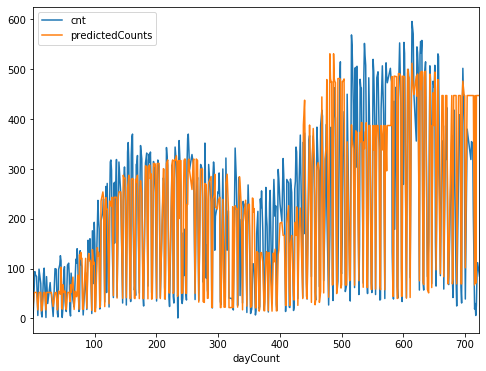

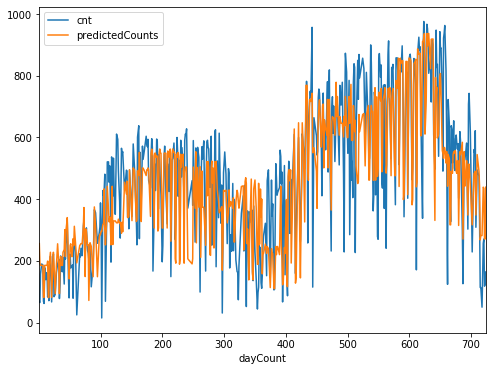

In [92]:
# Just to plot, try to add more details to the plots

times = [7,17]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    train_set_freg_time = train_set_freg[train_set.hr == time]
    train_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    train_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts', ax =ax)
    plt.show()

### Fine-tuning the model

**Task 1:** Assign different combination of max_depth and min_samples_leaf and min_samples_split to param_grid - 'max_depth': [28, 30, 32, 34, 36], 'min_samples_leaf': [5, 10, 15, 12],'min_samples_split': [120, 128, 136]

**Task 2:** Calculate the best parameter using GridSearchCV and store it in grid_search. 

**Task 3:** Fit the training dataset to the calculated best parameter model using the fit() method.

**Task 4:** Calculate the importance score for each of the feature.

In [99]:
from sklearn.model_selection import GridSearchCV

# Task 1
param_grid = [
    {'max_depth': [28, 30, 32, 34, 36], 'min_samples_leaf': [5, 10, 15, 12],'min_samples_split': [120, 128, 136]},
]

# Task 2
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

# Task 3
grid_search.fit(trainingCols, trainingLabels)
print(grid_search.best_params_)

# See the importance score of each attribute in GridSearchCV
# Task 4
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

{'max_depth': 28, 'min_samples_leaf': 5, 'min_samples_split': 120}
[0.72327956 0.12625232 0.15046812]


### Evaluate the model on test dataset

**Task 1:** Extract the relevant data from test_set and store it in X_test
		
**Task 2:** Extract the relevant data from test_set and store it in y_test

**Task 3:** Calculate the predicted values from the model and store it in 'predictedCounts_test' 

**Task 4:** Calculate the mean squared error using mean_squared_error function.

In [100]:
final_model = grid_search.best_estimator_

test_set.sort_values('dayCount', axis= 0, inplace=True)

# Task 1: Extract relevant columns from the test dataset
test_x_cols = ['xformWorkHr', 'temp','dayCount']

# Task 2: Extract relevant label from test set
test_y_cols = 'cnt'

X_test = test_set.loc[:,test_x_cols]
y_test = test_set.loc[:,test_y_cols]

# Task 3: Calculate the predicted values from the model and store it in 'predictedCounts_test'
test_set.loc[:,'predictedCounts_test'] = final_model.predict(X_test)

# Task 4: Calculate the mean squared error using mean_squared_error function.
final_mse = mean_squared_error(y_test, test_set.loc[:,'predictedCounts_test'])
print(np.sqrt(final_mse))
test_set.describe()

59.3046972835476


/Users/toluwalasheomotunde/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/toluwalasheomotunde/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Unnamed: 0,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,isWorking,monthCount,xformHr,dayCount,xformWorkHr,cntDeTrended,predictedCounts_test
count,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000
mean,8660.421557,2.481204,0.504411,6.480437,11.471423,0.030687,3.001534,0.685846,1.422133,-0.012980,-0.002944,0.012217,185.322785,0.685846,12.533372,11.415036,360.850898,18.954737,-3.852672,186.242785
std,4986.462636,1.110062,0.500028,3.457991,6.887845,0.172484,1.995486,0.464223,0.637995,0.993567,0.995428,1.006002,177.755171,0.464223,6.843005,6.909181,207.769276,13.057057,171.964728,163.645556
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.477205,-3.251166,-1.553889,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-274.491766,2.197558
25%,4338.750000,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,-0.815304,-0.763143,-0.699689,41.000000,0.000000,7.000000,5.000000,180.781250,8.000000,-124.743847,49.452716
50%,8697.000000,2.000000,1.000000,6.000000,11.000000,0.000000,3.000000,1.000000,1.000000,0.015647,0.014364,0.031899,136.000000,1.000000,13.000000,11.000000,362.375000,17.000000,-37.980680,141.641884
75%,12890.500000,3.000000,1.000000,9.000000,17.000000,0.000000,5.000000,1.000000,2.000000,0.742729,0.791871,0.519896,277.000000,1.000000,18.000000,17.000000,537.104167,28.000000,81.281369,272.805968
max,17377.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,2.404630,1.932215,5.399871,977.000000,1.000000,24.000000,23.000000,724.041667,47.000000,726.303828,798.842563


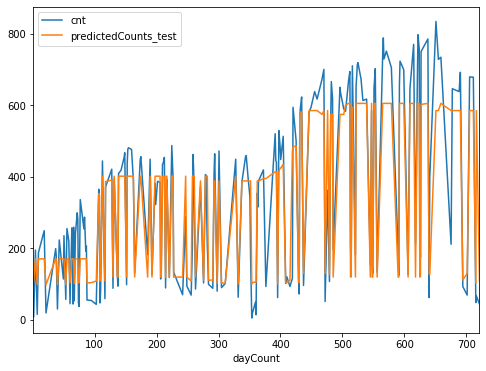

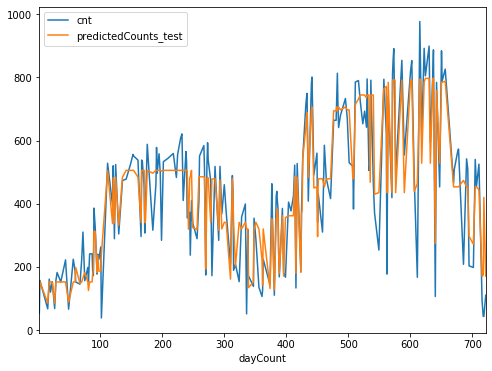

In [101]:
times = [8,18]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    test_set_freg_time = test_set[test_set.hr == time]
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts_test', ax =ax)
    plt.show()

### Analyzing the residuals
Analyzing the difference between the actual and the calculated values

Plotting the histogram for the observed difference

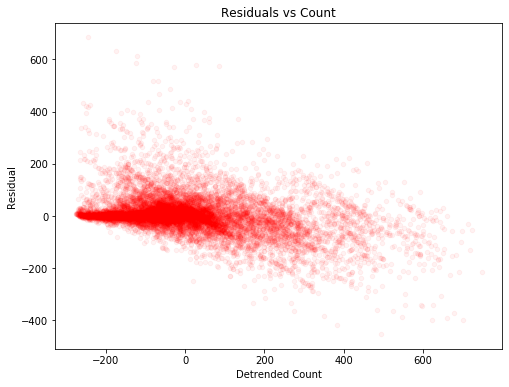

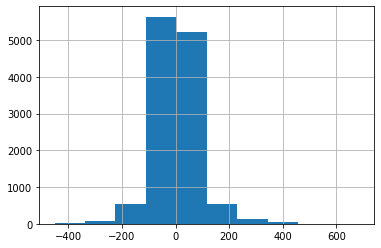

In [102]:
import statsmodels.api as sm

## Plot the residuals vs the label, the count of rented bikes.
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.plot(kind = 'scatter', x = 'cntDeTrended', y = 'resids', alpha = 0.05, color = 'red', ax = ax)
plt.xlabel("Detrended Count")
plt.ylabel("Residual")
plt.title("Residuals vs Count")
plt.show()

## Plotting the residuals
train_set_freg['resids'].hist()
plt.show()

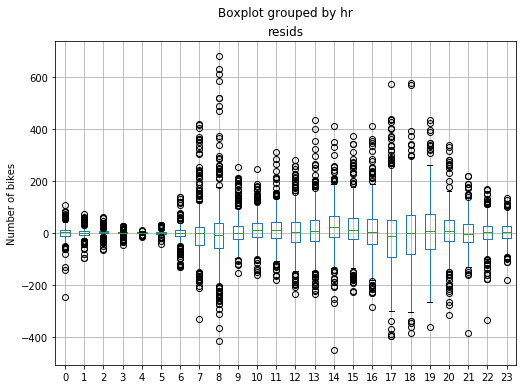

In [103]:
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.boxplot(column = ['resids'], by = ['hr'], ax = ax)
plt.xlabel('')
plt.ylabel('Number of bikes')
# plt.title(lab)
plt.show()

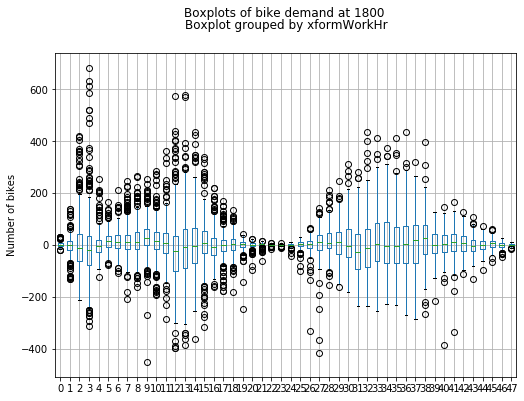

In [104]:
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.boxplot(column = ['resids'], by = ['xformWorkHr'], ax = ax)
plt.xlabel('')
plt.ylabel('Number of bikes')
plt.title(lab)
plt.show()

### Building a Transformation Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [ ]:
columnsToDrop = ['instant','casual','registered','atemp','dteday']
bikesData = bikesData.drop(columnsToDrop,1)

bikesData['isWorking'] = np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)
bikesData['monthCount'] = mnth_cnt(bikesData)
bikesData['xformHr'] = np.where(bikesData.hr>4,bikesData.hr-5,bikesData.hr+19)
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData['xformWorkHr'] = bikesData.isWorking*24 + bikesData.xformHr
bikesData = set_day(bikesData)
bikesData.describe()

columnsToScale = ['temp','hum','windspeed']
scaler = StandardScaler()
bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
arry = bikesData[columnsToScale].as_matrix()
bikesData[columnsToScale] = preprocessing.scale(arry)



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        isWorking = np.where(np.logical_and(X.loc[:,'workingday']==1,X.loc[:,'holiday']==0),1,0)
        xformHr = np.where(X.loc[:,'hr']>4,X.loc[:,'hr']-5,X.loc[:,'hr']+19)
        xformWorkHr = isWorking*24 + xformHr
        return np.c_[X, isWorking, xformHr, xformWorkHr]

In [ ]:
attr_adder = CombinedAttributesAdder()
bikesData1 = attr_adder.transform(bikesData)
bikesData = pd.DataFrame(bikesData1, columns=list(bikesData.columns)+["isWorking", "xformHr", "xformWorkHr"])
bikesData.head()